In [1]:
# Import libraries
import pandas as pd
import csv, html, re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Load data (path may be different: data is available at URL provided by README.md)
data = pd.read_csv("drive/MyDrive/drugsComTrain_raw.tsv", sep='\t', skiprows=[8072]).drop('Unnamed: 0', axis = 1)
data['review'] = data['review'].apply(html.unescape)

In [4]:
# View data head
data.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


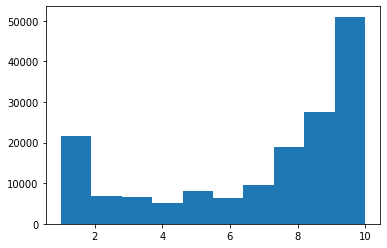

In [5]:
# See overall rating distribution
plt.hist(data['rating']);

In [6]:
# Drop NA. Create 'data_clean' dataset
data_clean = data.dropna(subset = ['condition'], axis = 0)
# Drop meaningless conditions
data_clean = data_clean[data_clean['condition'].apply(lambda x: not bool(re.search('</span>', x)))]

In [7]:
# Which drug has major application?
data_clean.groupby(['drugName','condition'], as_index= False).count().groupby('drugName', as_index= False).count().max()
# accetable: 4% of overall conditions

drugName       femhrt
condition          38
review             38
rating             38
date               38
usefulCount        38
dtype: object

In [8]:
# Define negative/positive ratings thresholds
positive = 7
negative = 6

In [9]:
# Binarization of ratings
data_clean = data_clean[(data_clean['rating'] >= positive) | (data_clean['rating'] <= negative)]
data_clean['positiveness'] = data_clean['rating'].apply(lambda x: 1 if (x >= positive) else -1)
np.sort(data_clean['rating'].unique())

array([ 1.,  2.,  3.,  4.,  7.,  8.,  9., 10.])

In [10]:
# Count positive and negative ratings. Save it in 'group' dataset
group = data_clean.groupby(['condition', 'positiveness'], as_index= False).count().sort_values(['condition', 'positiveness'])
group['drugName'] = group['drugName'] * group['positiveness']
group.head()

,condition,positiveness,drugName,review,rating,date,usefulCount
0,ADHD,-1,-653,653,653,653,653
1,ADHD,1,2443,2443,2443,2443,2443
2,AIDS Related Wasting,-1,-1,1,1,1,1
3,AIDS Related Wasting,1,3,3,3,3,3
4,AV Heart Block,-1,-1,1,1,1,1


In [11]:
# Drop unique ratings
names = pd.DataFrame(group.groupby('condition', as_index = False).count())
names = list(names[names['positiveness'] > 1]['condition'])
names[:10]

['ADHD',
 'AIDS Related Wasting',
 'Abnormal Uterine Bleeding',
 'Abortion',
 'Acne',
 'Actinic Keratosis',
 'Acute Coronary Syndrome',
 'Acute Lymphoblastic Leukemia',
 'Adrenocortical Insufficiency',
 'Agitated State']

In [12]:
# Count: positive ratings - negative ratings
group = group.groupby('condition').sum()[['drugName']]
group.head()

,drugName
condition,
ADHD,1790
AIDS Related Wasting,2
AV Heart Block,-1
Abdominal Distension,2
Abnormal Uterine Bleeding,-507


In [14]:
# Create balanced dataset named 'drug'
dataset = data_clean
drug = pd.DataFrame(columns = [*dataset.columns])
for name in names:
  nrew = group.loc[name]['drugName']
  if nrew < 0:
    more, less = -1, 1
  else:
    more, less = 1, -1
  df = dataset[(dataset['positiveness'] == more) & (dataset['condition'] == name)]
  df = df.drop(df.sample(n = abs(nrew), random_state = 123).index)
  drug = pd.concat([drug, df])
  drug = pd.concat([drug, dataset[(dataset['positiveness'] == less) & (dataset['condition'] == name)]])

In [15]:
drug.shape

(76200, 7)

In [20]:
drug.to_csv('data_train_balanced.csv')
!cp data_train_balanced.csv "drive/My Drive/"